In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from typing import List, Tuple
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.datasets.folder as folder
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchinfo import summary
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy
from sklearn.metrics import roc_curve, roc_auc_score, auc
from torchvision.models.densenet import DenseNet201_Weights
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from helper_functions import plot_loss_curves
import matplotlib.pyplot as plt
import requests
import engine
import zipfile
import os
import numpy as np
import random
from PIL import Image
from pathlib import Path

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_path = Path("plates/")
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)

There are 3 directories and 0 images in 'plates'.
There are 2 directories and 0 images in 'plates\hidden'.
There are 0 directories and 5 images in 'plates\hidden\clean'.
There are 0 directories and 5 images in 'plates\hidden\dirty'.
There are 2 directories and 0 images in 'plates\test'.
There are 0 directories and 150 images in 'plates\test\clean'.
There are 0 directories and 300 images in 'plates\test\dirty'.
There are 2 directories and 0 images in 'plates\train'.
There are 0 directories and 150 images in 'plates\train\clean'.
There are 0 directories and 150 images in 'plates\train\dirty'.


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"
hidden_dir = image_path / "hidden"
train_dir, test_dir, hidden_dir

(WindowsPath('plates/train'),
 WindowsPath('plates/test'),
 WindowsPath('plates/hidden'))

### Visualization 

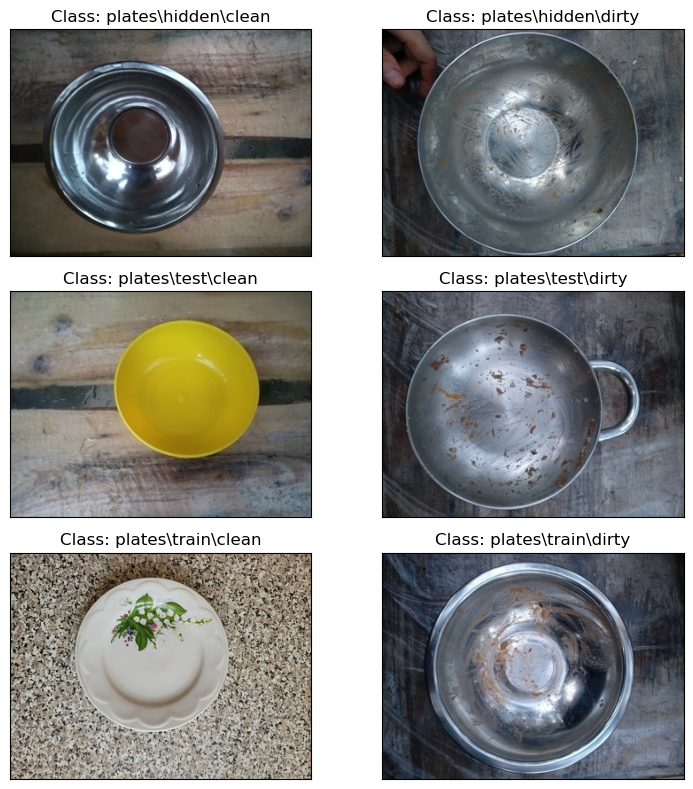

In [6]:
random.seed(42)
images = []
for subdir, dirs, files in os.walk(image_path):
    if len(files) > 0:
        img_file = random.choice([f for f in files if f.endswith(('jpg'))])
        img = Image.open(os.path.join(subdir, img_file))
        images.append((img, subdir.split("/")[-1]))

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8,8))
axs = axs.flatten()
for i, (img, subdir_name) in enumerate(images):
    axs[i].set_title(f'Class: {subdir_name}')
    axs[i].imshow(img)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.tight_layout()
plt.show()

### Transforming data 

In [7]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

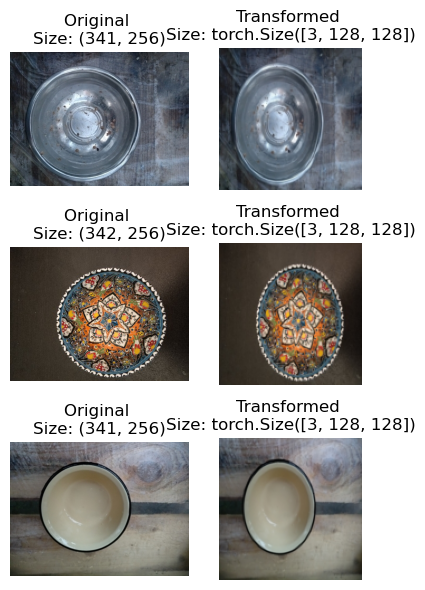

In [8]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    image_paths = random.sample(image_paths, n)
    images = []
    for path in image_paths:
        image = folder.default_loader(path)
        transformed_image = transform(image)
        images.append((image, transformed_image))
        
    # Plot the original and transformed images
    fig, axs = plt.subplots(n, 2, figsize=(4, 2*n))
    for i, (image, transformed_image) in enumerate(images):
        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f"Original \nSize: {image.size}")
        axs[i, 0].axis('off')
        axs[i, 1].imshow(transformed_image.permute(1, 2, 0)) 
        axs[i, 1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        axs[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

image_paths = []
for root, dirs, files in os.walk(image_path):
    for file in files:
        if file.endswith('.jpg'):
            image_paths.append(os.path.join(root, file))

plot_transformed_images(image_paths, transform=data_transform, n=3)

In [9]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None) 

test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 300
    Root location: plates\train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 450
    Root location: plates\test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [10]:
len(train_data), len(test_data)

(300, 450)

In [11]:
class_names = train_data.classes
class_dict = train_data.class_to_idx

In [12]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()//2
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False) # don't usually need to shuffle testing data


Creating DataLoader's with batch size 32 and 6 workers.


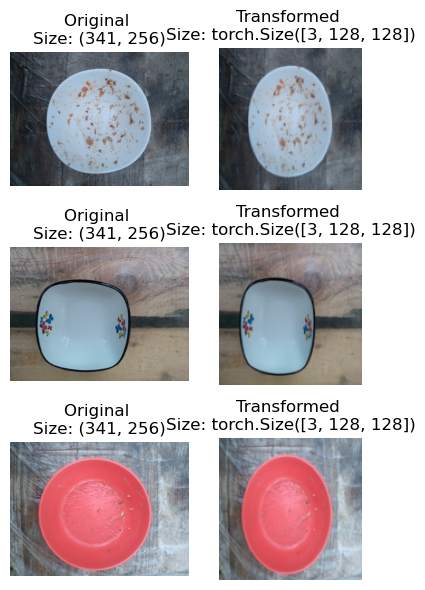

In [13]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_transformed_images(
    image_paths=image_path_list,
    transform=data_transform,
    n=3,
    seed=None)

# Model

### Model_0 TinyVGG

In [14]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.ReLU(),
            nn.Conv2d(hidden_units*2, hidden_units*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units*2, hidden_units*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU(),
            nn.Conv2d(hidden_units*4, hidden_units*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        num_features = hidden_units * 4 * (128 // 8) * (128 // 8)  # 128 is input image size, 8 is the result of three 2x2 max-pooling layers
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(in_features=num_features, out_features=hidden_units*4*2),
            nn.BatchNorm1d(hidden_units*4*2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_units*4*2, output_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.classifier(x)
        return x


In [15]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [16]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    model.eval() 
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred_logits = model(X)
            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()   
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [17]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
     #  Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [21]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)
NUM_EPOCHS = 10
model_0 = TinyVGG(input_shape=3, hidden_units=16, output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

start_time = timer()
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6646 | train_acc: 0.6365 | test_loss: 0.9513 | test_acc: 0.3125
Epoch: 2 | train_loss: 0.4208 | train_acc: 0.7979 | test_loss: 1.1900 | test_acc: 0.3125
Epoch: 3 | train_loss: 0.3919 | train_acc: 0.7958 | test_loss: 0.7628 | test_acc: 0.5687
Epoch: 4 | train_loss: 0.3387 | train_acc: 0.8479 | test_loss: 0.4821 | test_acc: 0.7708
Epoch: 5 | train_loss: 0.2799 | train_acc: 0.8979 | test_loss: 0.3912 | test_acc: 0.8167
Epoch: 6 | train_loss: 0.2228 | train_acc: 0.9354 | test_loss: 0.2918 | test_acc: 0.8667
Epoch: 7 | train_loss: 0.2893 | train_acc: 0.8646 | test_loss: 0.1760 | test_acc: 0.9417
Epoch: 8 | train_loss: 0.2098 | train_acc: 0.9229 | test_loss: 0.2323 | test_acc: 0.9021
Epoch: 9 | train_loss: 0.2053 | train_acc: 0.9073 | test_loss: 0.2399 | test_acc: 0.9125
Epoch: 10 | train_loss: 0.1730 | train_acc: 0.9281 | test_loss: 0.1989 | test_acc: 0.9333
Total training time: 78.323 seconds


In [22]:
def plot_loss_curves(results: dict[str, list[float]]):
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

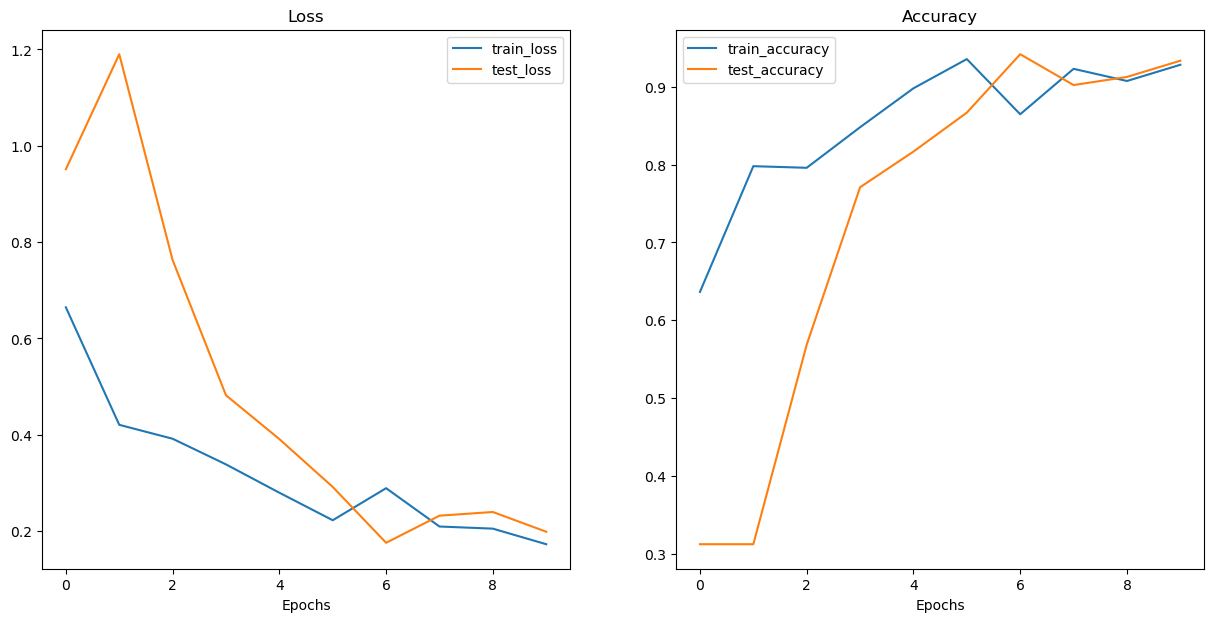

In [23]:
plot_loss_curves(model_0_results)

### Transfer Learning Model

In [21]:
model = torchvision.models.densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)

num_features = model.classifier.in_features
num_classes = len(class_names)
model.classifier = nn.Linear(num_features, num_classes)
model = model.to(device)

In [22]:
# Data transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None) 

test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()//2

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False) # don't usually need to shuffle testing data


In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
for param in model.parameters():
    param.requires_grad = False
output_shape = len(class_names)
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1920, out_features=1024),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1024, out_features=output_shape, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [24]:
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1920, 7, 7]     --                   False
│    └─Conv2d (conv0)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (relu0)                           [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56]     [32, 32, 56, 

In [25]:
start_time = timer()

torch.autograd.set_detect_anomaly(True)

results, best_model = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Best loss: 0.2750 | Counter: 0 | Stop: False
Epoch: 1 | train_loss: 0.6836 | train_acc: 0.6542 | test_loss: 0.2750 | test_acc: 0.9146
Best loss: 0.1549 | Counter: 0 | Stop: False
Epoch: 2 | train_loss: 0.3406 | train_acc: 0.8604 | test_loss: 0.1549 | test_acc: 0.9208
Best loss: 0.1100 | Counter: 0 | Stop: False
Epoch: 3 | train_loss: 0.2488 | train_acc: 0.9052 | test_loss: 0.1100 | test_acc: 0.9583
Best loss: 0.1100 | Counter: 1 | Stop: False
Epoch: 4 | train_loss: 0.1584 | train_acc: 0.9531 | test_loss: 0.1627 | test_acc: 0.9250
Best loss: 0.0956 | Counter: 0 | Stop: False
Epoch: 5 | train_loss: 0.1202 | train_acc: 0.9656 | test_loss: 0.0956 | test_acc: 0.9583
Best loss: 0.0956 | Counter: 1 | Stop: False
Epoch: 6 | train_loss: 0.1107 | train_acc: 0.9563 | test_loss: 0.0955 | test_acc: 0.9646
Best loss: 0.0889 | Counter: 0 | Stop: False
Epoch: 7 | train_loss: 0.1428 | train_acc: 0.9531 | test_loss: 0.0889 | test_acc: 0.9688
Best loss: 0.0889 | Counter: 1 | Stop: False
Epoch: 8 | train_

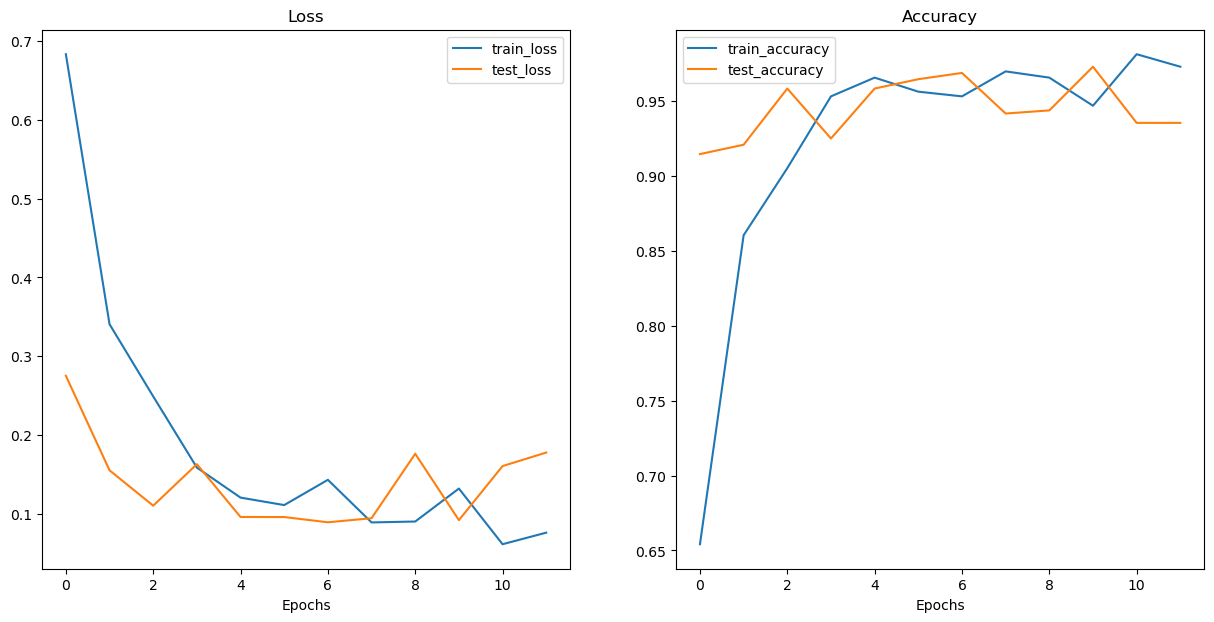

In [26]:
plot_loss_curves(results)

# Make Predictions

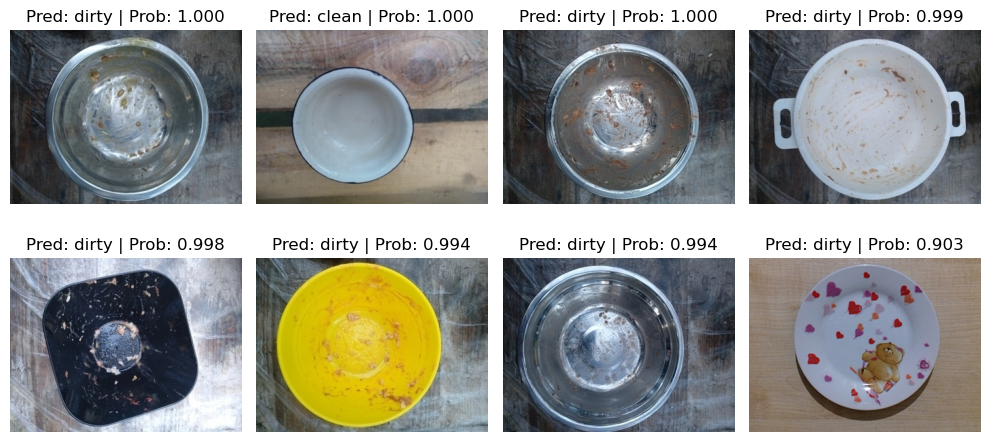

In [27]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):

    img = Image.open(image_path)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
        
    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    return img, target_image_pred_label, target_image_pred_probs

num_images_to_plot = 8
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) 
test_image_path_sample = random.sample(population=test_image_path_list, 
                                       k=num_images_to_plot)

# Set up the grid for plotting
num_rows = 2
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))
axes = axes.flatten()

for i, image_path in enumerate(test_image_path_sample):
    img, pred_label, pred_probs = pred_and_plot_image(model=best_model, 
                                                      image_path=image_path,
                                                      class_names=class_names,
                                                      image_size=(224, 224))
    axes[i].imshow(img)
    axes[i].set_title(f"Pred: {class_names[pred_label]} | Prob: {pred_probs.max():.3f}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

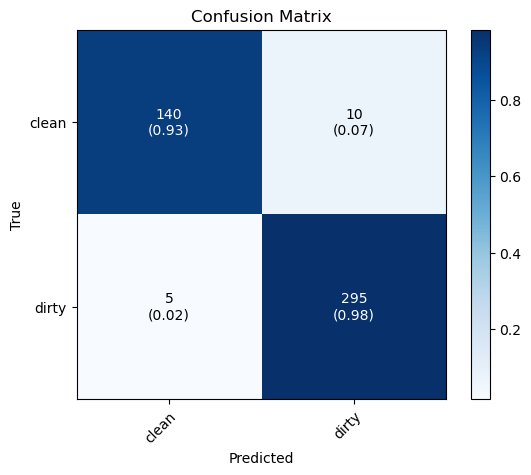

In [28]:
def get_all_preds_and_labels(model, dataloader):
    all_preds = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu())
            all_labels.extend(labels.cpu())
            
    return torch.stack(all_preds), torch.stack(all_labels)

preds, labels = get_all_preds_and_labels(best_model, test_dataloader)

# Compute confusion matrix
num_classes = len(class_names)
confmat_metric = ConfusionMatrix(num_classes=len(class_names), task='binary')
confmat_metric.update(preds, labels)
confusion_matrix = confmat_metric.compute().cpu().numpy()

# Visualize confusion matrix using mlxtend.plotting.plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [29]:
# precision and recall
precision = torchmetrics.Precision(average='macro', task='binary')
recall = torchmetrics.Recall(average='macro', task='binary')
precision_score = precision(preds, labels)
recall_score = recall(preds, labels)

# F1-score using precision and recall
f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)

one_hot_preds = torch.zeros(preds.size(0), len(class_names))
one_hot_preds.scatter_(1, preds.unsqueeze(1), 1)

roc_auc = torchmetrics.AUROC(pos_label=1, task='binary')
roc_auc_score = roc_auc(one_hot_preds[:, 1], labels)

print(f"Precision: {precision_score:.4f}")
print(f"Recall: {recall_score:.4f}")
print(f"F1-score: {f1_score:.4f}")
print(f"ROC-AUC Score: {roc_auc_score:.4f}")


Precision: 0.9672
Recall: 0.9833
F1-score: 0.9752
ROC-AUC Score: 0.9583


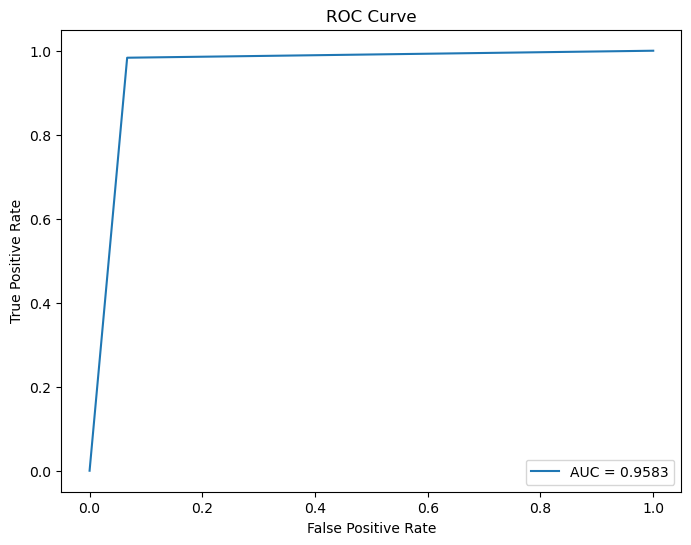

In [30]:
# ROC Curve
if len(preds.shape) > 1 and preds.shape[1] == 2:
    # Convert preds to probabilities
    softmax = torch.nn.Softmax(dim=1)
    probs = softmax(preds).cpu().numpy()
    y_score = probs[:, 1]
else:
    y_score = preds.cpu().numpy()

fpr, tpr, _ = roc_curve(labels, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("ROC Curve")
plt.show()

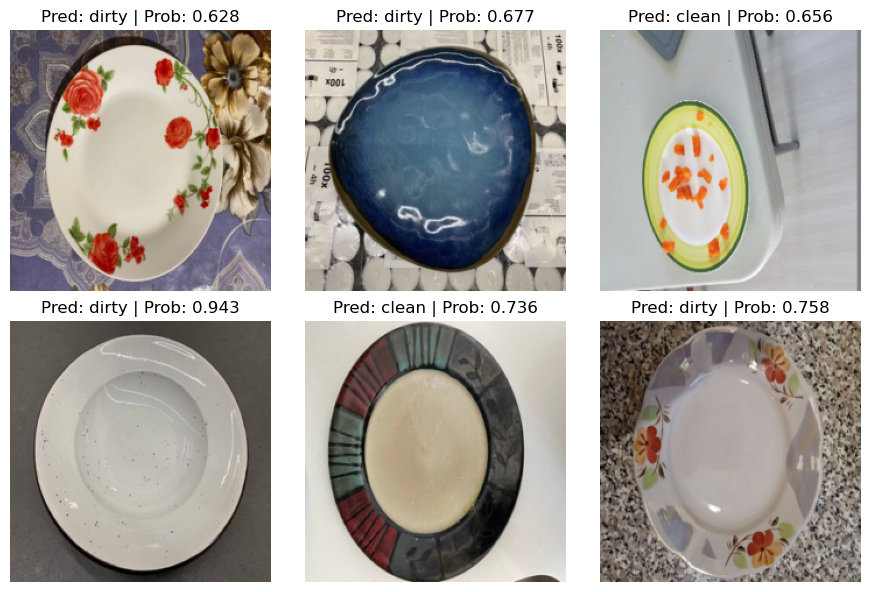

In [31]:
# Plotting misclassified images
def get_misclassified_images(model: torch.nn.Module,
                             dataloader: torch.utils.data.DataLoader,
                             device: torch.device):
    misclassified_images = []

    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

            misclassified_indices = (y_pred_class != y)
            misclassified_images.extend(X[misclassified_indices])

    return misclassified_images

def pred_and_plot_image(ax, model: torch.nn.Module,
                        img_tensor: torch.Tensor, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    def denormalize(tensor, mean, std):
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return tensor
    
    img_tensor = img_tensor.clone().detach()
    img = denormalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = img.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
        
    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(Image.fromarray(np.uint8(img * 255))).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    ax.imshow(img)
    ax.set_title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    ax.axis(False)

num_misclassified_images_to_plot = 6
misclassified_images = get_misclassified_images(best_model, test_dataloader, device)
misclassified_images_sample = random.sample(population=misclassified_images, k=num_misclassified_images_to_plot)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
axes = axes.ravel()

for idx, misclassified_image in enumerate(misclassified_images_sample):
    pred_and_plot_image(axes[idx], model=best_model,
                        img_tensor=misclassified_image,
                        class_names=class_names,
                        transform=data_transform)

plt.tight_layout()
plt.show()

# Deployment

In [32]:
# Save the best model's weights
model_weights_path = "best_model_weights.pth"
torch.save(best_model.state_dict(), model_weights_path)

print(f"Best model weights saved to {model_weights_path}")

Best model weights saved to best_model_weights.pth


### New model for test

In [34]:
model_T = torchvision.models.densenet201(pretrained=False)

num_features = model_T.classifier.in_features

# Modify the classifier to match the structure of the pre-trained weights
new_classifier = nn.Sequential(
    nn.Linear(num_features, 1024), 
    nn.ReLU(inplace=True),
    nn.Linear(1024, len(class_names))
)

model_T.classifier = new_classifier

state_dict = torch.load('best_model_weights.pth')
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith('classifier.1'):
        new_key = key.replace('classifier.1', 'classifier.0')
    elif key.startswith('classifier.4'):
        new_key = key.replace('classifier.4', 'classifier.2')
    else:
        new_key = key
    new_state_dict[new_key] = value

model_T.load_state_dict(new_state_dict)
# Freeze
for param in model_T.parameters():
    param.requires_grad = False

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_T.classifier.parameters(), lr=0.001, momentum=0.9)

data_T_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_data_T = datasets.ImageFolder(root=hidden_dir, transform=data_T_transform)
NUM_WORKERS = os.cpu_count()//2
dataloader_T = DataLoader(test_data_T, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_T.to(device)
model_T.eval()

# Evaluate the model
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for inputs, labels in dataloader_T:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_T(inputs)
        _, preds = torch.max(outputs, 1)

        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

test_accuracy = correct_predictions / total_predictions
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9000
